# EarthShape Phase 2: Overview of time-slice simulations

This notebook provides a brief overview of the simulated timeslices and some examples for working with the netcdf files produced by the postprocessing tooling for [EarthShape](http://earthshape.net/) Phase 2.

__________________
<img src="images/logo_earthshape.png" width="330" align="right">

Christian Werner  
christian.werner@kit.edu  
IMK-IFU, Karlsruhe Institute for Technology, Garmisch-Partenkirchen  
2019-06-01

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as plt
import matplotlib.ticker as mticker
import pandas as pd
from pathlib import Path
import sys
import xarray as xr
from IPython.display import Markdown, display, HTML

def check_version():
    def rtext(t): return '<span style="color: #ff0000">'+t+'</span>'
    if float('.'.join([str(x) for x in sys.version_info[0:2]] )) < 3.6:
        display(Markdown(rtext('This notebook is written for Python 3.6 and up!')))
        
check_version()

In [128]:
# for plotting we also use a custom repo. Install directly from github by uncommenting this line and executing it...
lpjguesstools_source = 'git+https://github.com/cwerner/lpjguesstools.git#egg=lpjguesstools'
! pip install -U {lpjguesstools_source}
import lpjguesstools.plotting as lpjp
from lpjguesstools.lgt_biomize.biomes_earthshape import biomes, biome_color

  Cloning https://github.com/cwerner/lpjguesstools.git to /tmp/pip-install-x1k754z4/lpjguesstools
  Stored in directory: /tmp/pip-ephem-wheel-cache-6f0q_49n/wheels/bc/f7/9b/44ba5c5a90df1a06f04bebd601e6b5536746edec669503baa1
Successfully built lpjguesstools
  Found existing installation: lpjguesstools 0.0.2
    Uninstalling lpjguesstools-0.0.2:
      Successfully uninstalled lpjguesstools-0.0.2


### Constants

In [14]:
ts = ['pre_industrial', 'lgm', 'pliocene', 'middle_miocene']
tsl = dict(zip(ts, ['Pre-Ind.', 'LGM', 'Pliocene', 'Mid. Miocene']))

sites = ['Nahuelbuta', 'La Campana', 'St. Gracia', 'Pan de Azucar']
sites_short = ['4','3','2','1']
coords = [(-37.81,    -73.0145),
          (-32.92917, -71.08835),
          (-29.75116, -71.15858), 
          (-26.10910, -70.4503)]   # original PdA: -26.10910, -70.5503
site_coords = dict(zip(ts, coords))

df_sites = pd.DataFrame(dict(site=sites, siteno=sites_short, coord=coords)).sort_values(by='siteno').reset_index(drop=True)

# invert mapping 
#inv_map = {v: k for k, v in tsl.items()}

### Utility functions

In [15]:
# extend path object
Path.ls = lambda x: [o.name for o in x.iterdir()]

# nicer plots
def beautify_map(ax, label=None, add_marker=False):
    """Take an axis and apply some styling"""
    
    gl = ax.gridlines(draw_labels=True, linestyle='--', color='black', alpha=.5)
    gl.xlocator = mticker.FixedLocator([-80, -75, -70, -65])
    gl.ylocator = mticker.FixedLocator([-10, -20, -30, -40, -50, -60])
    gl.xlabels_top = False
    gl.ylabels_right = False
    ax.add_feature(cfeature.LAND, facecolor="whitesmoke")
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.set_extent([-78,-65,-58,-14])
    if label: ax.set_title(label)
    if add_marker:
        lats = [a[0] for a in coords]
        lons = [a[1] for a in coords]
        ax.scatter(lons, lats, transform=ccrs.Geodetic(), color='red', s=10)
        for i, txt in enumerate(sites_short):
            ax.annotate(' '+sites_short[i], (lons[i]*0.98, lats[i]*1.03), 
                        transform=ccrs.Geodetic(), color='red', 
                        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round'))
        


## Input: Climate data

Climate data was provided by Sebastian Mutz (Uni Tübingen). The time slices are:

|Time-slice      |Code |Time    |CO$_2$|Status    |Comment                       |
|:---------------|:----|:-------|:-----|:---------|:-----------------------------|  
|Present Day     |e004 |.       |348   |NA        |used for bias correction only, p.d. (1978-1996)	e5 default	p.d. mean (1957-2000)	e5 default (CO2: 348ppm, CH4:1.65ppm) |
|Pre Industrial  |e007 |.       |280   |**Done**  |amip pre-industry	PI co2(280ppm),ch4(760ppb),n2o(270ppb)echam def          |
|Middle Holocene |e008 |.       |280   |NA        |e5 default	AWI_MH_clim_sst	co2(280ppm),ch4(650ppb),n2o(270ppb)              |
|LGM             |e009 |.       |185   |**Done**  |reconstructed LGM, AWI_LGM_clim_sst, LGM co2(185ppm),ch4(350ppb),n2o(200ppb)  |
|Pliocene        |e010 |.       |405   |**Done**  |reconsructed from PRISM datasets	reconstructed from PRISM dataset, Pliocene co2(405ppm), others using PI ch4(760ppb),n2o(270ppb)         |
|Late Miocene    |e012 |11-7 ma |450   |NA        |Greenland ice removed; hudson bay filled with low elevation (5meter); Austria moved southeast wards for 5 grid boxes;Vegetation from Michel et al. 2011;south antartic ice 1/4 of the present; rest are the same as PI, knorr and Lohmann 2014, ICE Quarter CO2 450ppm	CO2 (450ppm) others PI values       |
|Middle Miocene  |e011 |14 ma   |278   |**Done**  |Greenland ice removed; hudson bay filled with low elevation (5meter); Austria moved southeast wards for 5 grid boxes;Vegetation from Michel et al. 2011; rest are the same as PI	Knorr and Lohmann 2014, ICE Full CO2 278ppm run	CO2(278ppm) others PI values                            |


## Results: Vegetation

In [16]:
# show current results
path = Path('../results')
path.ls()

['es2_middle_miocene_biome.nc',
 'es2_pre_industrial_biome.nc',
 'es2_middle_miocene_avg.nc',
 'es2_lgm_avg.nc',
 'es2_pliocene_avg.nc',
 'es2_pre_industrial_avg.nc',
 'es2_lgm_biome.nc',
 'es2_pliocene_biome.nc']

In [17]:
# load data
ds = {}
for t in ts: ds[t] = xr.open_dataset(path/f'es2_{t}_avg.nc')

In [18]:
# these are the ES sites
display(HTML('<H4>EarthShape Sites</H4>'), HTML(df_sites.to_html(index=False)))

site,siteno,coord
Pan de Azucar,1,"(-26.1091, -70.4503)"
St. Gracia,2,"(-29.75116, -71.15858)"
La Campana,3,"(-32.92917, -71.08835)"
Nahuelbuta,4,"(-37.81, -73.0145)"


### Leaf Area Index (LAI)

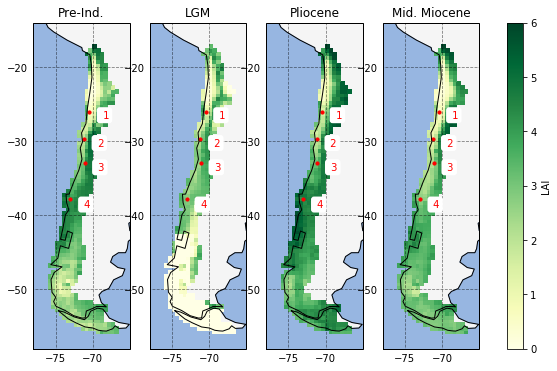

In [19]:
# plot average LAI
fig, axes = plt.subplots(1, len(ts), subplot_kw={'projection': ccrs.PlateCarree()})

for t, ax in zip(ts, axes.flatten()):
    p = ds[t].tot_sp_lai.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='YlGn', vmin=0, vmax=6, add_colorbar=False, rasterized=True)
    beautify_map(ax, label=tsl[t], add_marker=True)
fig.colorbar(p, ax=axes.ravel().tolist()).set_label('LAI');

plt.gcf().set_size_inches(10, 6) # bigger plot

### Vegetation cover

In [20]:
# convert LAI to FPC
import numpy as np
for t in ts:
    ds[t]['vegcover'] = xr.zeros_like(ds[t].tot_sp_lai)
    ds[t]['vegcover'] = (1.0 - np.exp(-0.5 * ds[t]['tot_sp_lai'])) * 100

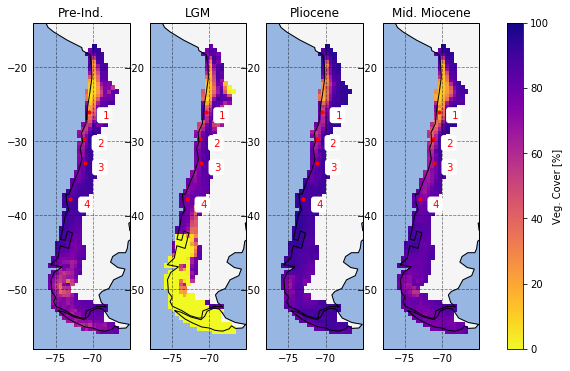

In [21]:
# plot average veg cover
fig, axes = plt.subplots(1, len(ts), subplot_kw={'projection': ccrs.PlateCarree()})

for t, ax in zip(ts, axes.flatten()):
    p = ds[t].vegcover.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='plasma_r', vmin=0, vmax=100, add_colorbar=False, rasterized=True)
    beautify_map(ax, label=tsl[t], add_marker=True)
fig.colorbar(p, ax=axes.ravel().tolist()).set_label('Veg. Cover [%]');

plt.gcf().set_size_inches(10, 6) # bigger plot

### Average vegetation cover for EarthShape sites (corresponding grid cells)


,pre_industrial,lgm,pliocene,middle_miocene
Nahuelbuta,86.69,77.49,88.51,76.56
La Campana,77.22,75.10,79.25,67.03
St. Gracia,64.66,70.52,63.71,49.21
Pan de Azucar,28.35,50.63,55.21,16.92


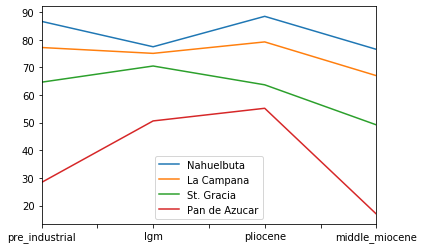

In [53]:
df_veg = pd.DataFrame(np.zeros((len(sites), len(ts))), columns=ts, index=sites)

for t in ts:
    for s in sites:
        lat, lon = df_sites.loc[df_sites.site == s,'coord'].iloc[0]
        vcover = ds[t].vegcover.sel(lat=lat, lon=lon, method='nearest').values.round(2)
        df_veg.loc[s,t] = vcover

df_veg.T.plot(); df_veg

In [75]:
! ls -l ../results

total 3200
-rw-r--r-- 1 root root 538596 Jun  3 08:29 es2_lgm_avg.nc
-rw-r--r-- 1 root root 216670 Jun  3 08:29 es2_lgm_biome.nc
-rw-r--r-- 1 root root 623782 Jun  3 08:29 es2_middle_miocene_avg.nc
-rw-r--r-- 1 root root 217267 Jun  3 08:29 es2_middle_miocene_biome.nc
-rw-r--r-- 1 root root 626338 Jun  3 08:29 es2_pliocene_avg.nc
-rw-r--r-- 1 root root 216950 Jun  3 08:29 es2_pliocene_biome.nc
-rw-r--r-- 1 root root 606656 Jun  3 08:29 es2_pre_industrial_avg.nc
-rw-r--r-- 1 root root 216874 Jun  3 08:29 es2_pre_industrial_biome.nc


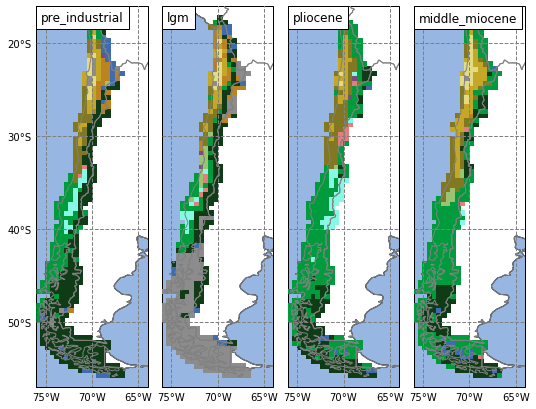

In [129]:
# load biome data
ds_biome = {}
for t in ts: ds_biome[t] = xr.open_dataset(path/f'es2_{t}_biome.nc')

# create biome map for time slices
mc = lpjp.MapContainer(names=ts, nrows_ncols=(1,len(ts)+1), figsize=(14,7), spatial=True)
for i, t in enumerate(ts):
    mc.add(i, ds_biome[t]['biome'])
mc.plot_data_discrete(biome=biomes, color_mapping=biome_color)

In [172]:
import matplotlib.patches as mpatches

def create_legend():
   
    fg_color='black'

    D_short2long = dict(D='Desert', 
                        ASh='Arid Shrubland',
                        Mat='Matorral',
                        St='Steppe', 
                        SclW='Sclerophyllous Woodland',
                        DMF='Deciduous \'Maule\' Forest',
                        MixF='Mixed Forest',
                        NPL='Nothofagus Parkland',
                        VRF='Valdivian Rainforest',
                        MeW='Mesic Woodland',
                        CDF='Cold Deciduous Forest',
                        MFW='Magellanic Forest/ Woodl.')

    cs = []
    labs = []

    for b in biomes.items:
        print(b)
        if b == 99:
            break

        if biomes.reverse_mapping[b] == 'NPL':
            continue

        short_name = biomes.reverse_mapping[b]
        color = biome_color[b]
        long_name = D_short2long[short_name]

        cs.append( mpatches.Patch(color=color) )
        labs.append(long_name)

    ncols = 2
    fig = plt.figure()
    figlegend = plt.figure(figsize=(4,2))
    ax = fig.add_subplot(111)
    #fig, ax = plt.subplots(1, figsize=(3, 3))

    print(cs)
    
    display(fig)
    lpft = figlegend.legend(cs, labs, loc='center', ncol=ncols, prop={'size':8} )
    
    display(lpft)
    
    lpft.get_frame().set_linewidth(0.0)
    lpft.get_frame().set_facecolor('white')
    for text in lpft.get_texts():
        text.set_color(fg_color)

    display(fig)

0
1
2
3
4
5
6
7
8
9
10
11
99
[<matplotlib.patches.Patch object at 0x7f0704f6a6d8>, <matplotlib.patches.Patch object at 0x7f0704f6a438>, <matplotlib.patches.Patch object at 0x7f06a972a4a8>, <matplotlib.patches.Patch object at 0x7f06a972a518>, <matplotlib.patches.Patch object at 0x7f0711dbd0b8>, <matplotlib.patches.Patch object at 0x7f0704e32f60>, <matplotlib.patches.Patch object at 0x7f0704e32e80>, <matplotlib.patches.Patch object at 0x7f0704e32dd8>, <matplotlib.patches.Patch object at 0x7f0704e32be0>, <matplotlib.patches.Patch object at 0x7f0704fb9828>, <matplotlib.patches.Patch object at 0x7f0704fb98d0>]


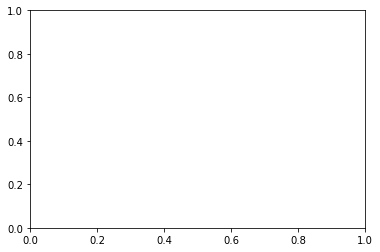

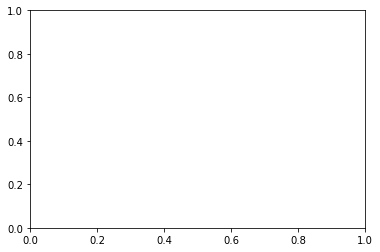

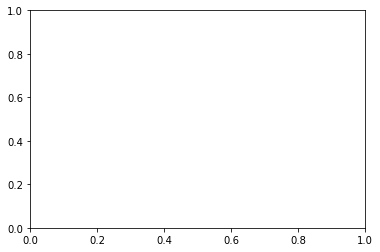

<Figure size 288x144 with 0 Axes>

In [173]:
create_legend()

# CHECK/ TODO
- Check climate for desert regions (aka Pan de Azucar)  
  *Seems that we do have too much veg there. Is the bias-correction in deserts off?*
  *Further investigation shows that we have a coastal wet cell that is picked for PdA. Mitigate by moving site lat slightly east for now,
  but values are still higher than in Werner et al., 2018*
- Prepare site climate file from compressed netcdf formats

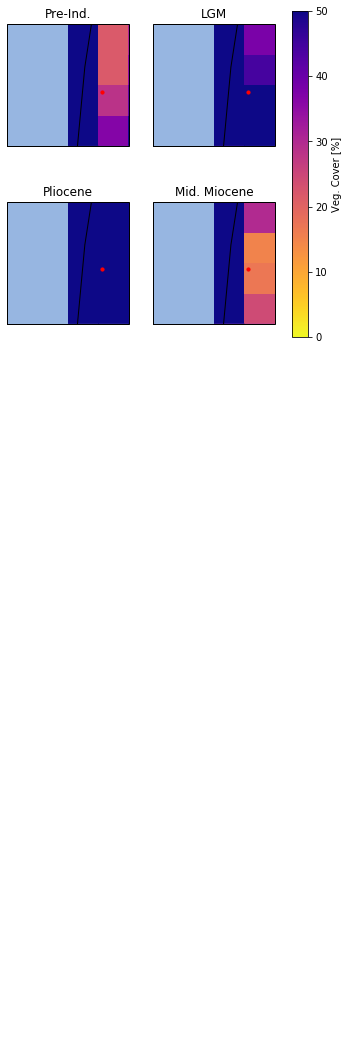

In [27]:
# plot average veg cover (check PdA problem)
fig, axes = plt.subplots(2, len(ts)//2, subplot_kw={'projection': ccrs.PlateCarree()})

for t, ax in zip(ts, axes.flatten()):
    p = ds[t].vegcover.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='plasma_r', vmin=0, vmax=50, add_colorbar=False, rasterized=True)
    beautify_map(ax, label=tsl[t], add_marker=True)
    ax.set_extent([-72,-70,-27,-25])
fig.colorbar(p, ax=axes.ravel().tolist()).set_label('Veg. Cover [%]');

plt.gcf().set_size_inches(6, 6) # bigger plot